# Analyzing Creditworthiness in Fintech

Kaggle Competition: https://www.kaggle.com/competitions/home-credit-default-risk/overview

# Pipeline 1: LightGBM Predictor

In [2]:
%%time
# main_pipeline.py
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

from src import data_utils
from pipelines.estimators import (
    CorrectOutliers,
    CustomOrdinalEncoder,
    CustomOneHotEncoder,
    CustomImputer,
    CustomBackup,
    CustomScaler,
    CustomDropna
)
from pipelines.smart_pandas import PandasFeatureUnion
from lightgbm_custom.lgbm_estimators import LGBMPredictor, LGBMFeatureSelector


# app_train, app_test, columns_description = data_utils.get_datasets()
app_train = pd.read_csv("dataset/application_train_aai.csv")
app_test = pd.read_csv("dataset/application_test_aai.csv")
columns_description  = pd.read_csv("dataset/HomeCredit_columns_description.csv")

X_train, y_train, X_test, y_test = data_utils.get_feature_target(app_train, app_test)
X_train, X_val, y_train, y_val = data_utils.get_train_val_sets(X_train, y_train)

dtype_object_info = (X_train.loc[:, (X_train.dtypes == "object").values]
        .apply(lambda x: x.to_frame().drop_duplicates().value_counts(), axis=0)
        .sum())

assert isinstance(dtype_object_info, pd.core.series.Series), "type error"


# Numerical or Datetime features
num_dt_ft = X_train.loc[:, (X_train.dtypes != "object").values].columns.tolist()
# Object type features with two unique categories
two_cat_ft = dtype_object_info[dtype_object_info == 2].index.to_list()
# Object type features with more than two unique categories
plus_two_cat_ft = dtype_object_info[dtype_object_info > 2].index.to_list()


workflow_1 = PandasFeatureUnion([
    ("num_dt_cat", FunctionTransformer(lambda X: X[num_dt_ft].reset_index())),
    ("binary_cat", CustomOrdinalEncoder(two_cat_ft)),
    ("multi_label_cat", CustomOneHotEncoder(plus_two_cat_ft)),
    ])

feature_enginering = Pipeline([
    ("outliers", CorrectOutliers()),
    ("numerical_transformation", workflow_1),
    ("impute_nan", CustomImputer(strategy="median")),
    ("backup", CustomBackup(shutdown=True)),
    ("remove_nan", CustomDropna()),
    ("scale", CustomScaler(scaler=StandardScaler)),
    ])

feature_enginering.fit(X_train)
val_data = feature_enginering.transform(X_val)

params = {
    "objective": "binary",
    "metric": "auc",
    "min_child_samples": 2000,
    "num_leaves": 14,
    "learning_rate": 0.1,
    "random_state": 88,
    "n_jobs": -1,
    "verbose": 0,
}

feature_model_pipeline = Pipeline([
    ("feature_enginering", feature_enginering),
    ("model", LGBMPredictor(params=params, val_data=val_data, y_val=y_val)),
])

feature_model_pipeline.fit(X_train, y_train)

Downloading...
From: https://drive.google.com/uc?id=1e8jbK4zNv95Yd2acycf27MbrDcCwAgFS&confirm=t
To: c:\Users\Agustin\Proyectos 2023\Diciembre\AnyoneAI\assignment\dataset\HomeCredit_columns_description.csv
100%|██████████| 24.6k/24.6k [00:00<00:00, 649kB/s]
Downloading...
From: https://drive.google.com/uc?id=1vT0u2xndjNFIE-gCoW7s0tJuV4aPyz0B&confirm=t
To: c:\Users\Agustin\Proyectos 2023\Diciembre\AnyoneAI\assignment\dataset\application_train_aai.csv
100%|██████████| 132M/132M [00:04<00:00, 32.6MB/s] 



Training LightGBM Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[234]	training's auc: 0.791357	valid_1's auc: 0.75453
CPU times: total: 1min 9s
Wall time: 40.9 s


Pipeline(steps=[('feature_enginering',
                 Pipeline(steps=[('outliers', CorrectOutliers()),
                                 ('numerical_transformation',
                                  PandasFeatureUnion(transformer_list=[('num_dt_cat',
                                                                        FunctionTransformer(func=<function <lambda> at 0x000002A0BD64D6C0>)),
                                                                       ('binary_cat',
                                                                        CustomOrdinalEncoder(columns=['NAME_CONTRACT_TYPE',
                                                                                                      'FLAG_OWN_CAR',
                                                                                                      'FLAG_OWN_REALTY',
                                                                                                      'EMERGENCYSTATE_MODE']...
49199                 -0.522724                        1.939808   
49200                 -0.522724                       -0.515515   
49201                 -0.522724                        1.939808   

       WALLSMATERIAL_MODE_Wooden  
0                      -0.132211  
1                      -0.132211  
2                      -0.132211  
3                      -0.132211  
4                      -0.132211  
...                          ...  
49197                  -0.132211  
49198                  -0.132211  
49199                  -0.132211  
49200                  -0.132211  
49201                  -0.132211  

[49202 rows x 242 columns],
                               y_val=9122      0
133133    0
3214      0
124219    1
224022    0
         ..
18787     1
106493    0
26045     0
58869     0
55593     0
Name: TARGET, Length: 49202, dtype: int64))])

## Pipeline 2: MBFs Assembly Model
### Mindful Business Focus solution

Assembly model with the following Models:
- Base Model: Logistic Regression
- Shallow Neural Network
- Deep Neural Network

All models are feed with the same data, the features selected are the output of the feature selection process.

The feature selection process is based on the following steps:
- The previous required steps for preprocessing the data
- Training a LightGBM model
- Selecting the features with the highest importance (with score bigger than 0)

After the feature selection process we instanciate the three models that conform the assembly model.

We put the models inside a FeatureUnion pipeline, so we can train the three models at the same time.

If we call this last step the "head" of the MBFs model, we can say that the solution is practical because it has the same interface as a single model, but if we want to optimize the training time a better solution would be to train them in parallel processes.

As we use a FeatureUnion pipeline, we cannot use the final pipeline to make predictions, it's a pipeline only for training.

When the training is finished, we can isolate each model accessing the pipeline attribute `transformer_list` and then the attribute `named_steps` of the pipeline holding each model.

From there, we have a Scikit-Learn Estimator that holds the original model in the attribute `model`.

<br />

One goal of this project was to create a Scikit-Learn pipeline that can be feed it with pandas.DataFrame and return a pandas.DataFrame with the transformation (preserve Type). This was achieved with OOP. We create a class called `PandasFeatureUnion` that inherits from `FeatureUnion`. In this class we override the methods `fit` and `transform` to make them work with pandas.DataFrame.

<br />

The main goal was to create pipeline 3. But in this presentation we are going to show you 3 pipelines, pipeline 1 is the LightGBM model trained for predicting the target variable, pipeline 2 is the LightGBM model trained for feature selection, and pipeline 3 is the MBFs Assembly Model.

<br />

At the end we are going to evaluate each model metrics and compare them.

<br />

In [4]:
%%time
import main_pipeline_4 as mp4
mp4.mbfs_pipeline


Training LGBM Feature Selector Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[234]	training's auc: 0.791357	valid_1's auc: 0.75453
Train shape: (196806, 132)
val shape: (49202, 132)
	  Initializing Logistic Regression

Parameters:  {'random_state': 42, 'C': 0.001}
	  Initializing Shallow NN

Learning rate:  1.8
Number of iterations:  800
	  Initializing Multi Layer NN

Layers dimensions:  [132, 132, 50, 1]
Learning rate:  0.5
Number of iterations:  500

Training LGBM Feature Selector Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[234]	training's auc: 0.791357	valid_1's auc: 0.75453

Training Logistic Regression Model


Training Shallow Neural Network Model

Number of training examples: 196806
Number of testing examples: 49202
Training set shape: (196806, 132)
Training vector shape: (1, 196806)
Testing set shape: (49202, 132)
Testing vector shape: (1, 49202)

(SNN) Cost a

Pipeline(steps=[('feature_enginering',
                 Pipeline(steps=[('outliers', CorrectOutliers()),
                                 ('numerical_transformation',
                                  PandasFeatureUnion(transformer_list=[('num_dt_cat',
                                                                        FunctionTransformer(func=<function <lambda> at 0x000002A0BD64E3E0>)),
                                                                       ('binary_cat',
                                                                        CustomOrdinalEncoder(columns=['NAME_CONTRACT_TYPE',
                                                                                                      'FLAG_OWN_CAR',
                                                                                                      'FLAG_OWN_REALTY',
                                                                                                      'EMERGENCYSTATE_MODE']...
4                      1.913056                       -0.515515  
...                         ...                             ...  
49197                 -0.522724                       -0.515515  
49198                 -0.522724                       -0.515515  
49199                 -0.522724                        1.939808  
49200                 -0.522724                       -0.515515  
49201                 -0.522724                        1.939808  

[49202 rows x 132 columns],
                                                                                                     Y_test=9122      0
133133    0
3214      0
124219    1
224022    0
         ..
18787     1
106493    0
26045     0
58869     0
55593     0
Name: TARGET, Length: 49202, dtype: int64,
                                                                                                     layers_dim=[132,
                                                                                                                 132,
                                                                                                                 50,
                                                                                                                 1],
                                                                                                     learning_rate=0.5,
                                                                                                     num_iterations=500,
                                                                                                     print_cost=True))]))]))])

# Conclusion

Before we start comparing the models of the assembly model, we are going to evaluate the performance of the LightGBM model trained for predicting the target variable.
In adition we are going to define a threshold for labeling the predictions in the test set.

In [5]:
# Obtain feature sets
train_features = mp4.feature_selection_pipeline.transform(X_train)
val_features = mp4.feature_selection_pipeline.transform(X_val)
test_features = mp4.feature_selection_pipeline.transform(X_test)

# Obtain models
log_reg = mp4.MBFs.named_transformers["base_model"].named_steps["customlogisticregression"]
snn = mp4.MBFs.named_transformers["snn"].named_steps["shallownnbinaryclassifier"]
mlnn = mp4.MBFs.named_transformers["mlnn"].named_steps["multilayernnbinaryclassifier"]

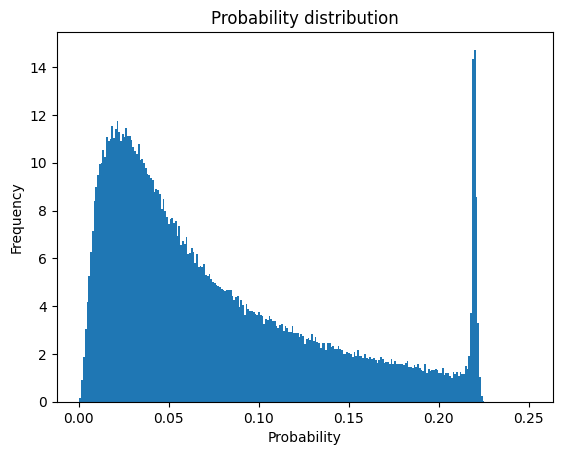

In [6]:
mlnn.plot_proba_dist(train_features)

In [16]:
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    confusion_matrix,
    auc
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
bias_coef = 1.14

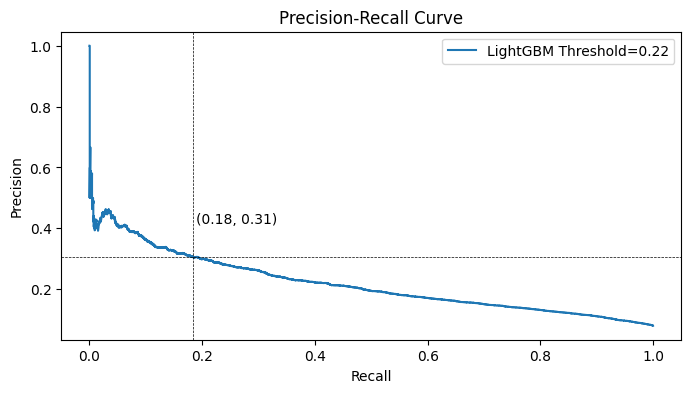

In [32]:
# predict probabilities
train_predict_proba = np.squeeze(mlnn.predict_proba(train_features))
val_predict_proba = np.squeeze(mlnn.predict_proba(val_features))
test_predict_proba = np.squeeze(mlnn.predict_proba(test_features))

# Precision-Recall Curve Values
precision_mlnn, recall_mlnn, thresholds_mlnn = precision_recall_curve(y_true=y_val, probas_pred=val_predict_proba)
mlnn_stats = pd.DataFrame({"precision":precision_mlnn,"recall": recall_mlnn,"threshold": (list(thresholds_mlnn) + [0.999])})

# Finding the balanced point
try:
    balanced_threshold = mlnn_stats.loc[(mlnn_stats["precision"] / mlnn_stats["recall"]) == 1]["threshold"].values[0]
    balanced_precision = mlnn_stats.loc[(mlnn_stats["precision"] / mlnn_stats["recall"]) == 1]["precision"].values[0]
    balanced_recall = mlnn_stats.loc[(mlnn_stats["precision"] / mlnn_stats["recall"]) == 1]["recall"].values[0]
except:
    aux = mlnn_stats[round(mlnn_stats["precision"] - mlnn_stats["recall"], 4) == 0]
    balanced_threshold = aux.iloc[round(len(aux)/2)]["threshold"]
    balanced_precision = aux.iloc[round(len(aux)/2)]["precision"]
    balanced_recall = aux.iloc[round(len(aux)/2)]["recall"]


# Applying bias 
threshold = balanced_threshold * bias_coef
precision = mlnn_stats.iloc[(mlnn_stats["threshold"] - threshold).abs().argsort()[:1]]["precision"].values[0]
recall = mlnn_stats.iloc[(mlnn_stats["threshold"] - threshold).abs().argsort()[:1]]["recall"].values[0]


# Precision-Recall Curve Plot
plt.figure(figsize=(8, 4))
plt.plot(recall_mlnn, precision_mlnn, label="LightGBM Threshold={:.2f}".format(threshold))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.axvline(x=recall, color="k", linewidth=0.5, linestyle="--")
plt.axhline(y=precision, color="k", linewidth=0.5, linestyle="--")

plt.text(recall+0.15, precision+0.1, f"({recall:.2f}, {precision:.2f})", fontsize=10, ha='right', va='bottom')
plt.legend()
plt.show();



Train ROC AUC Score: 0.7513
Validation ROC AUC Score: 0.7433
Validation set confusion matrix


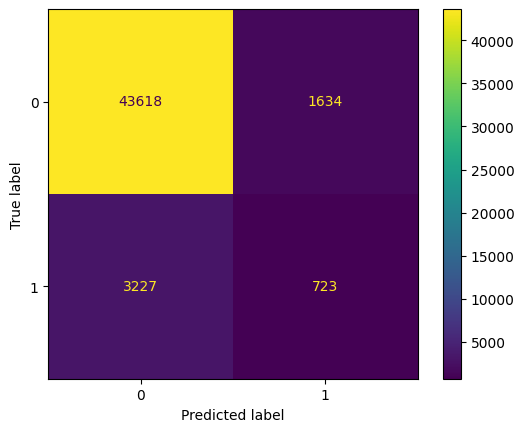

In [33]:
# Binarize Predictions
train_predict = (train_predict_proba > threshold).astype(int)
val_predict = (val_predict_proba > threshold).astype(int)
test_predict = (test_predict_proba > threshold).astype(int)
y_test_real = (y_test > threshold).astype(int)

# ROC AUC Score - Part 1
train_score = roc_auc_score(y_true=y_train, y_score=train_predict_proba)
val_score = roc_auc_score(y_true=y_val, y_score=val_predict_proba)
test_score = roc_auc_score(y_true=y_test_real, y_score=test_predict_proba)
print()
print("Train ROC AUC Score: {:.4f}".format(train_score))
print("Validation ROC AUC Score: {:.4f}".format(val_score))

# Confusion Matrix
confusion_val_mlnn = confusion_matrix(y_true=y_val, y_pred=val_predict)
print("Validation set confusion matrix")
ConfusionMatrixDisplay(confusion_val_mlnn).plot();

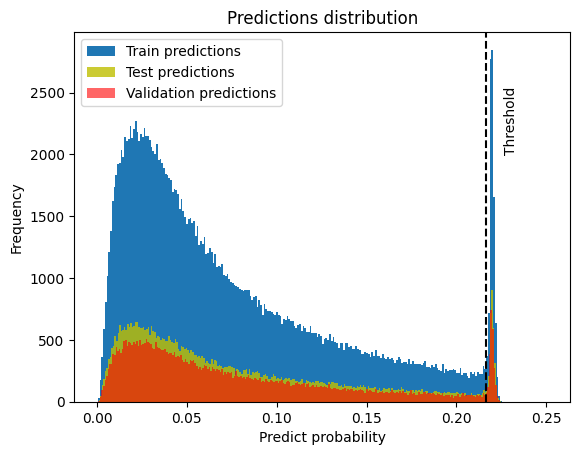

In [34]:
# Distribution of predictions Plot
ax1 = pd.Series(train_predict_proba).plot(kind="hist", bins=255, alpha=1)
ax2 = pd.Series(test_predict_proba).plot(kind="hist", bins=255, alpha=0.8, color="y")
ax3 = pd.Series(val_predict_proba).plot(kind="hist", bins=255, alpha=0.6, color="r")
ax3.set_xlabel("Predict probability")
ax3.set_title("Predictions distribution")
ax3.legend(["Train predictions", "Test predictions", "Validation predictions"])
ax3.axvline(x=threshold, color="k", linestyle="--")
ax3.text(
    threshold + 0.01,
    2000,# hardcoded
    "Threshold",
    rotation=90,
    verticalalignment="bottom",
    horizontalalignment="left",
    color="k",
    fontsize=10,
)
plt.show();

In [35]:
# accuracy score
train_score = accuracy_score(y_true=y_train, y_pred=train_predict)
val_score = accuracy_score(y_true=y_val, y_pred=val_predict)
test_score = accuracy_score(y_true=y_test_real, y_pred=test_predict)

print("Train accuracy score: {:.4f}".format(train_score))
print("Validation accuracy score: {:.4f}".format(val_score))
print("Test accuracy score: {:.4f}".format(test_score))

Train accuracy score: 0.9018
Validation accuracy score: 0.9012
Test accuracy score: 0.9552



Train ROC AUC Score: 0.7881
Validation ROC AUC Score: 0.7570


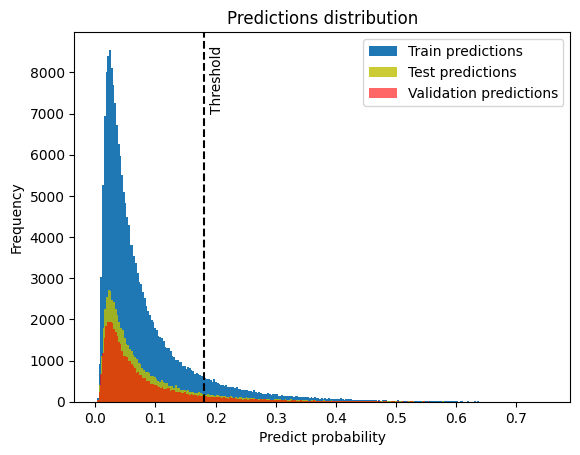

Test ROC AUC Score: 0.9737
Percentage difference Score (train - val): 3.1 %
CPU times: total: 15.8 s
Wall time: 9.95 s


In [ ]:
%%time
# Base Model Metrics
train_predict_proba = feature_model_pipeline.predict(X_train)
val_predict_proba = feature_model_pipeline.predict(X_val)
test_predict_proba = feature_model_pipeline.predict(X_test)

# Binarize Score
threshold = 0.18
train_predict = (train_predict_proba > threshold).astype(int)
val_predict = (val_predict_proba > threshold).astype(int)
test_predict = (test_predict_proba > threshold).astype(int)
y_test_real_lgbm = (y_test > threshold).astype(int)

# ROC AUC Score
train_score = roc_auc_score(y_true=y_train, y_score=train_predict_proba)
val_score = roc_auc_score(y_true=y_val, y_score=val_predict_proba)
test_score = roc_auc_score(y_true=y_test_real_lgbm, y_score=test_predict_proba)
print()
print("Train ROC AUC Score: {:.4f}".format(train_score))
print("Validation ROC AUC Score: {:.4f}".format(val_score))

ax1 = pd.Series(train_predict_proba).plot(kind="hist", bins=255, alpha=1)
ax2 = pd.Series(test_predict_proba).plot(kind="hist", bins=255, alpha=0.8, color="y")
ax3 = pd.Series(val_predict_proba).plot(kind="hist", bins=255, alpha=0.6, color="r")
ax3.set_xlabel("Predict probability")
ax3.set_title("Predictions distribution")
ax3.legend(["Train predictions", "Test predictions", "Validation predictions"])
ax3.axvline(x=threshold, color="k", linestyle="--")
ax3.text(
    threshold + 0.01,
    7000,#  hardcoded
    "Threshold",
    rotation=90,
    verticalalignment="bottom",
    horizontalalignment="left",
    color="k",
    fontsize=10,
)
plt.show()


print("Test ROC AUC Score: {:.4f}".format(test_score))
diff = round((train_score - val_score) *100, 1)
print(f"Percentage difference Score (train - val): {diff} %")

Training and Validation Set Confusion Matrix


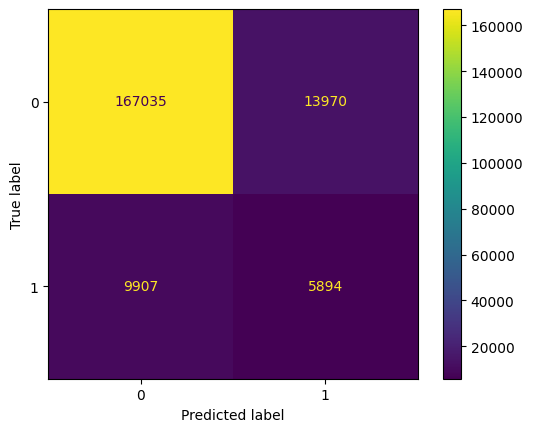

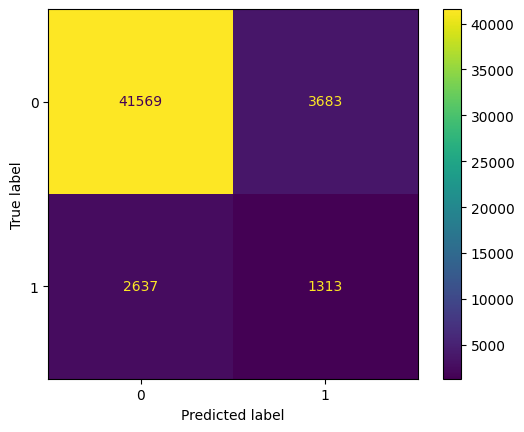

In [ ]:
print("Training and Validation Set Confusion Matrix")
ConfusionMatrixDisplay(confusion_matrix(y_train, train_predict)).plot()
ConfusionMatrixDisplay(confusion_matrix(y_val, val_predict)).plot();

### MBFs Evaluation

In [ ]:
# Obtain training features
train_features = mp3.feature_selection_pipeline.transform(X_train)
val_features = mp3.feature_selection_pipeline.transform(X_val)
test_features = mp3.feature_selection_pipeline.transform(X_test)

# Obtain models
log_reg = mp4.MBFs.named_transformers["base_model"].named_steps["customlogisticregression"]
# snn = mp4.MBFs.named_transformers["snn"].named_steps["shallownnbinaryclassifier"]
mlnn = mp4.MBFs.named_transformers["mlnn"].named_steps["multilayernnbinaryclassifier"]

# Obtain predictions
train_predict_proba_log_reg = log_reg.predict_proba(train_features)
val_predict_proba_log_reg = log_reg.predict_proba(val_features)
test_predict_proba_log_reg = log_reg.predict_proba(test_features)

# train_predict_proba_snn = snn.predict_proba(train_features)[0]
# val_predict_proba_snn = snn.predict_proba(val_features)[0]
# test_predict_proba_snn = snn.predict_proba(test_features)[0]

train_predict_proba_mlnn = mlnn.predict_proba(train_features)[0]
val_predict_proba_mlnn = mlnn.predict_proba(val_features)[0]
test_predict_proba_mlnn = mlnn.predict_proba(test_features)[0]

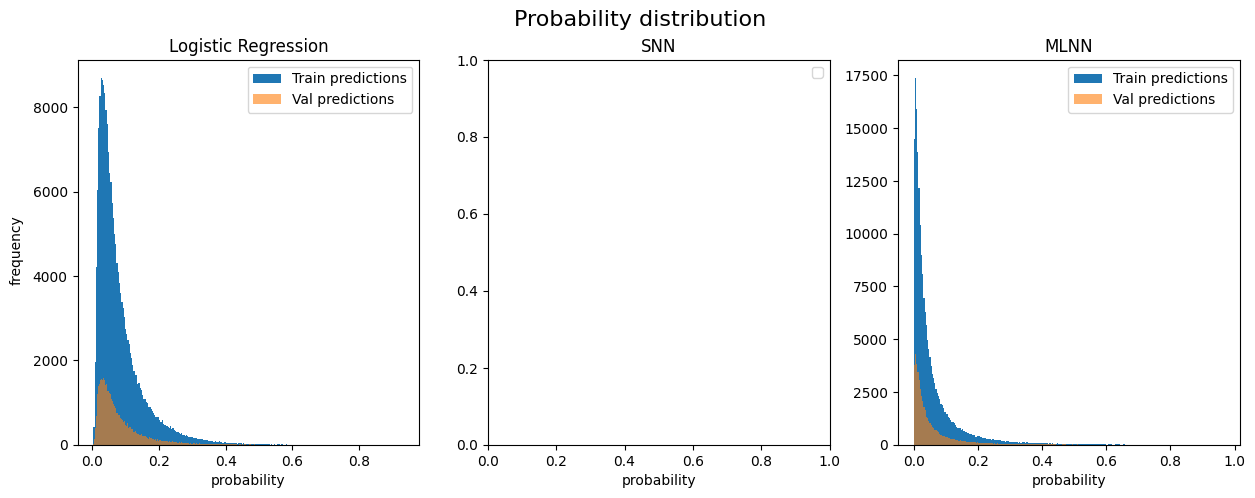

In [ ]:
# 1 crear un suplots de una fila y 3 columnas para graficar la distribución de probabilidades
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# 2 crear un titulo para el grafico que diga "Probability distribution"
fig.suptitle("Probability distribution", fontsize=16)

# 3 crear un titulo para cada subplot que diga "Logistic Regression", "SNN", "MLNN"
ax[0].set_title("Logistic Regression")
ax[1].set_title("SNN")
ax[2].set_title("MLNN")

# 4 crear un label para el eje x que diga "probability"
ax[0].set_xlabel("probability")
ax[1].set_xlabel("probability")
ax[2].set_xlabel("probability")

# 5 crear un label para el eje y que sea compartido por los 3 subplots que diga "frequency"
fig.text(0.08, 0.5, "frequency", va="center", rotation="vertical")

# 6 crear un histograma para cada subplot con las probabilidades de cada modelo
ax[0].hist(train_predict_proba_log_reg, bins=255, alpha=1)
# ax[1].hist(train_predict_proba_snn, bins=255, alpha=1)
ax[2].hist(train_predict_proba_mlnn, bins=255, alpha=1);
ax[0].hist(val_predict_proba_log_reg, bins=255, alpha=0.6)
# ax[1].hist(val_predict_proba_snn, bins=255, alpha=0.6)
ax[2].hist(val_predict_proba_mlnn, bins=255, alpha=0.6);

# Add legend
ax[0].legend(["Train predictions", "Val predictions"])
ax[1].legend(["Train predictions", "Val predictions"]);
ax[2].legend(["Train predictions", "Val predictions"]);

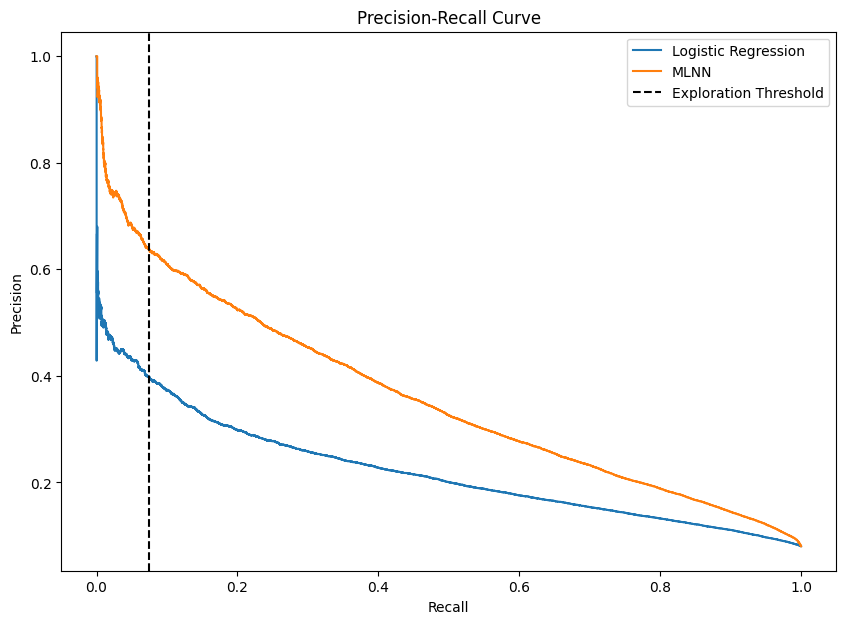

In [ ]:
# apply precision_Recall_curve function to each model
precision_log_reg, recall_log_reg, thresholds_log_reg = precision_recall_curve(y_train, train_predict_proba_log_reg)
# precision_snn, recall_snn, thresholds_snn = precision_recall_curve(y_train, train_predict_proba_snn)
precision_mlnn, recall_mlnn, thresholds_mlnn = precision_recall_curve(y_train, train_predict_proba_mlnn)

log_reg_stats= pd.DataFrame({"precision":precision_log_reg,"recall": recall_log_reg,"threshold": (list(thresholds_log_reg) + [0.999])})
# # # # snn_stats = pd.DataFrame({"precision":precision_snn,"recall": recall_snn,"threshold": (list(thresholds_snn) + [0.999])})
mlnn_stats = pd.DataFrame({"precision":precision_mlnn,"recall": recall_mlnn,"threshold": (list(thresholds_mlnn) + [0.999])})

# calculate auc for each model
auc_log_reg = auc(recall_log_reg, precision_log_reg)
# # # auc_snn = auc(recall_snn, precision_snn)
auc_mlnn = auc(recall_mlnn, precision_mlnn)

# plot precision-recall curve for each model
manual_threshold = 0.075
plt.figure(figsize=(10, 7))
plt.plot(recall_log_reg, precision_log_reg, label="Logistic Regression")
# # # plt.plot(recall_snn, precision_snn, label="SNN")
plt.plot(recall_mlnn, precision_mlnn, label="MLNN")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.axvline(x=manual_threshold, color="k", linestyle="--", label="Exploration Threshold")


plt.legend()
plt.show();

# # give me the best threshold for each model
# idx_log_reg = np.argmax(precision_log_reg - recall_log_reg)
# threshold_log_reg = thresholds_log_reg[idx_log_reg -1]
# print(f"Best threshold for Logistic Regression: {round(threshold_log_reg,3)}")

# idx_snn = np.argmax(precision_snn - recall_snn)
# threshold_snn = thresholds_snn[idx_snn-1]
# print(f"Best threshold for SNN: {round(threshold_snn,3)}")

# idx_mlnn = np.argmax(precision_mlnn - recall_mlnn)
# threshold_mlnn = thresholds_mlnn[idx_mlnn-1]
# print(f"Best threshold for MLNN: {round(threshold_mlnn, 3)}")
# We can see that the nature of the data is very unbalanced, so all the models feel more confortable predicting the majority class. That's why the "better threshold" is the one that maximize the F1 score.

#TODO: Buscar el valor de precision que es igual a recall, y ese el threshold balanceado, graficar lineas

**ESTE GRAFICO LO VAMOS A HACER MAS CHIQUITO Y PONERLO DENTRO DEL TRABAJO PARA EXPLICAR COMO ES QUE SE SELECCIONAR EL THRESHOLD BALANCEADO**

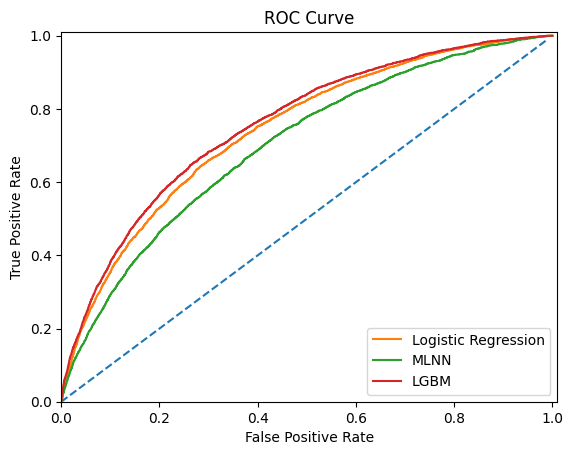

In [ ]:
from sklearn.metrics import roc_curve
fpr_log,tpr_log,thr_log = roc_curve(y_val, val_predict_proba_log_reg)
# fpr_snn,tpr_snn,thr_snn = roc_curve(y_val, val_predict_proba_snn)
fpr_mlnn,tpr_mlnn,thr_mlnn = roc_curve(y_val, val_predict_proba_mlnn)
fpr_lgbm,tpr_lgbm,thr_lgbm = roc_curve(y_val, val_predict_proba)

reg_log_df = pd.DataFrame(dict(fpr=fpr_log, tpr=tpr_log, thr = thr_log))
# # # # snn_df = pd.DataFrame(dict(fpr=fpr_snn, tpr=tpr_snn, thr = thr_snn))
mlnn_df = pd.DataFrame(dict(fpr=fpr_mlnn, tpr=tpr_mlnn, thr = thr_mlnn))
lgbm_df = pd.DataFrame(dict(fpr=fpr_lgbm, tpr=tpr_lgbm, thr = thr_lgbm))

plt.axis([0, 1.01, 0, 1.01])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01), linestyle="--")
plt.plot(reg_log_df["fpr"], reg_log_df["tpr"], label="Logistic Regression")
# # # plt.plot(snn_df["fpr"], snn_df["tpr"], label="SNN")
plt.plot(mlnn_df["fpr"], mlnn_df["tpr"], label="MLNN")
plt.plot(lgbm_df["fpr"], lgbm_df["tpr"], label="LGBM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show();

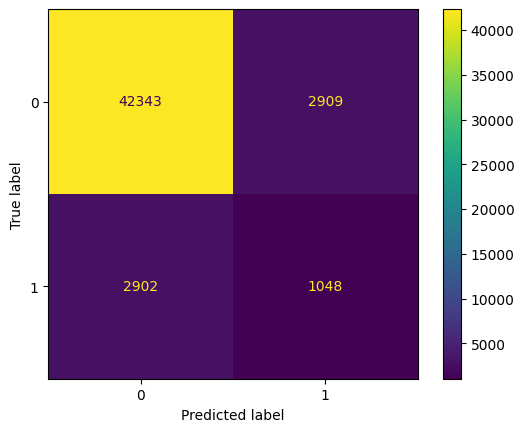

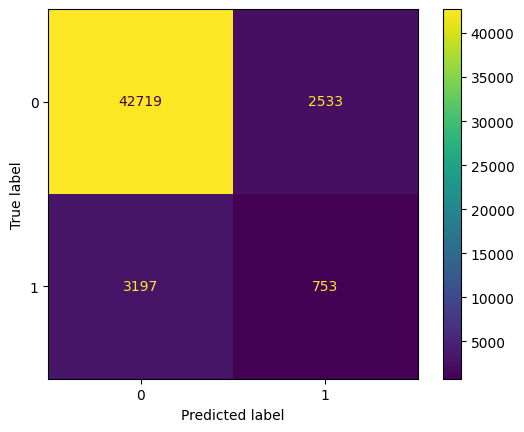

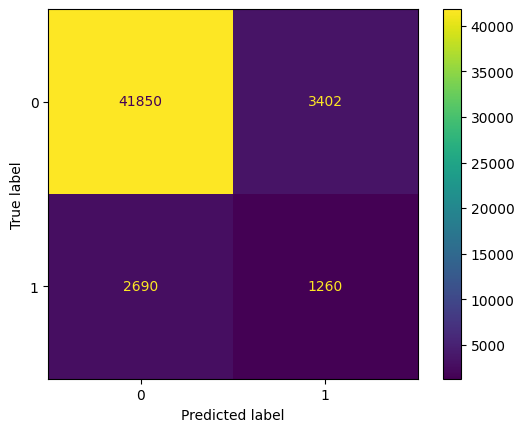

In [ ]:
# Confusion Matrix
# Model to optimize = MLNN (Multilayer Neural Network)
false_negative_best_threshold = mlnn_df.loc[(mlnn_df["fpr"] + (false_negative:=1 - mlnn_df["tpr"])).idxmin()]["thr"]
false_positive_best_threshold = mlnn_df.loc[(mlnn_df["tpr"] + (false_positive:=1 - mlnn_df["fpr"])).idxmax()]["thr"]

try:
    balanced_threshold = log_reg_stats.loc[(log_reg_stats["precision"] / log_reg_stats["recall"]) == 1]["threshold"].values[0]
except:
    aux = log_reg_stats[round(log_reg_stats["precision"] - log_reg_stats["recall"], 4) == 0]
    balanced_threshold = aux.iloc[round(len(aux)/2)]["threshold"]

bias_coef = 1
confusion_matrix_log_reg = confusion_matrix(y_val, val_predict_proba_log_reg > balanced_threshold*bias_coef)
# confusion_matrix_snn = confusion_matrix(y_val, val_predict_proba_snn > balanced_threshold*bias_coef)
confusion_matrix_mlnn = confusion_matrix(y_val, val_predict_proba_mlnn > balanced_threshold*bias_coef)
confusion_matrix_lgbm = confusion_matrix(y_val, val_predict_proba > balanced_threshold*bias_coef)

ConfusionMatrixDisplay(confusion_matrix_log_reg).plot()
# ConfusionMatrixDisplay(confusion_matrix_snn).plot()
ConfusionMatrixDisplay(confusion_matrix_mlnn).plot()
ConfusionMatrixDisplay(confusion_matrix_lgbm).plot();

In [ ]:
# Roc Auc Score
roc_auc_score_log_reg = roc_auc_score(y_val, val_predict_proba_log_reg)
# roc_auc_score_snn = roc_auc_score(y_val, val_predict_proba_snn)
roc_auc_score_mlnn = roc_auc_score(y_val, val_predict_proba_mlnn)
roc_auc_score_lgbm = roc_auc_score(y_val, val_predict_proba)

print("ROC AUC Score Logistic Regression: {:.4f}".format(roc_auc_score_log_reg))
# # print("ROC AUC Score SNN: {:.4f}".format(roc_auc_score_snn))
print("ROC AUC Score MLNN: {:.4f}".format(roc_auc_score_mlnn))
print("ROC AUC Score LGBM: {:.4f}".format(roc_auc_score_lgbm))

# Accuracy Score
accuracy_score_log_reg = accuracy_score(y_val, val_predict_proba_log_reg > balanced_threshold*bias_coef)
# # accuracy_score_snn = accuracy_score(y_val, val_predict_proba_snn > balanced_threshold*bias_coef)
accuracy_score_mlnn = accuracy_score(y_val, val_predict_proba_mlnn > balanced_threshold*bias_coef)
accuracy_score_lgbm = accuracy_score(y_val, val_predict_proba > balanced_threshold*bias_coef)

print("Accuracy Score Logistic Regression: {:.4f}".format(accuracy_score_log_reg))
# # print("Accuracy Score SNN: {:.4f}".format(accuracy_score_snn))
print("Accuracy Score MLNN: {:.4f}".format(accuracy_score_mlnn))
print("Accuracy Score LGBM: {:.4f}".format(accuracy_score_lgbm))
    

ROC AUC Score Logistic Regression: 0.7423
ROC AUC Score MLNN: 0.7007
ROC AUC Score LGBM: 0.7570
Accuracy Score Logistic Regression: 0.8675
Accuracy Score MLNN: 0.8736
Accuracy Score LGBM: 0.8614


In [ ]:
# True Negative (0,0) -> Cliente se predice que no paga y no paga
# False Positive (0,1) -> Cliente se predice que paga y no paga
# False Negative (1,0) -> Cliente se predice que no paga y paga
# True Positive (1,1) -> Cliente se predice que paga y paga

# Criterio es disminuir los false negative
# para eso el fpr tiene que ser lo mas bajo posible
# para eso el tpr tiene que ser lo mas alto posible

aux = mlnn_df#.iloc[8000:15000]
aux


,fpr,tpr,thr
0,0.000000,0.000000,1.968190e+00
1,0.000022,0.000000,9.681898e-01
2,0.000066,0.000000,8.398075e-01
3,0.000066,0.000253,7.819072e-01
4,0.000177,0.000253,7.347463e-01
...,...,...,...
6940,0.991183,0.999494,6.912792e-04
6941,0.991183,0.999747,6.875631e-04
6942,0.993039,0.999747,5.603254e-04
6943,0.993039,1.000000,5.597246e-04


# borrar de aca para abajo


In [ ]:
error
# Layers and Neurons
n_x = X.shape[1] # numero de input features
n_1 = 9
n_2 = 9
n_3 = 5 
n_4 = 3 
n_5 = 1

mlnn = MultiLayerNNClassifier(
    X_test=val_features,
    Y_test=y_val,
    layers_dim=[val_features.shape[1], val_features.shape[1], 1],
    learning_rate=0.5,
    num_iterations=500,
    print_cost=True,
)

NameError: name 'error' is not defined

In [ ]:
mlnn.fit(feature_selection_pipeline.transform(X_train), y_train)


Number of training examples: 196806
Number of testing examples: 49202
Training set shape: (196806, 127)
Training vector shape: (1, 196806)
Testing set shape: (49202, 127)
Testing vector shape: (1, 49202)
Cost after iteration 0: 0.6920171387452673
Cost after iteration 100: 0.25219529397968027
Cost after iteration 200: 0.24947404679751514
Cost after iteration 300: 0.24817598199758664
Cost after iteration 400: 0.24723820529287913
Cost after iteration 499: 0.2464932027820878


MultiLayerNNClassifier(X_test=          index  SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0      1.458711    1.434583     -0.579108          0.069524   -0.369118   
1      0.850524    0.240719     -0.579108         -0.196888    0.405252   
2     -0.175106    0.131363     -0.579108          0.085196   -0.369118   
3      0.822671   -0.012249     -0.579108         -0.306587    0.746142   
4     -1.079002    1.424390     -0.579108         -0.353601   -1.116676   
...         ...         ...           ...               ...         ...   
49197  1.450192   -0.627997      0.80443...
       WALLSMATERIAL_MODE_Stone_brick  
0                           -0.515420  
1                            1.940165  
2                            1.940165  
3                           -0.515420  
4                           -0.515420  
...                               ...  
49197                       -0.515420  
49198                       -0.515420  
49199                       -0.515420  
49200                       -0.515420  
49201                       -0.515420  

[49202 rows x 127 columns],
                       Y_test=226655    0
183464    0
110628    0
181486    0
46437     0
         ..
226050    0
38757     0
91305     1
66491     0
54500     0
Name: TARGET, Length: 49202, dtype: int64,
                       layers_dim=[127, 127, 1], learning_rate=0.5,
                       num_iterations=500, print_cost=True)

In [ ]:
y_val

226655    0
183464    0
110628    0
181486    0
46437     0
         ..
226050    0
38757     0
91305     1
66491     0
54500     0
Name: TARGET, Length: 49202, dtype: int64

# Two Layer Neural Network

In [ ]:
error

In [ ]:
## MAIN ## MAIN ## MAIN ## MAIN ## MAIN ## MAIN ## MAIN ##

X, Y, X_test, Y_test = feed_exploration(X, Y.to_frame(), X_val, Y_val.to_frame())


Number of training examples: 362154
Number of testing examples: 90360
train_x_orig shape: (362154, 127)
train_y shape: (1, 362154)
test_x_orig shape: (90360, 127)
test_y shape: (1, 90360)


In [ ]:
train_x_flatten = np.array(X, dtype=np.float64)
test_x_flatten = np.array(X_test, dtype=np.float64)
train_x_flatten = train_x_flatten.reshape(train_x_flatten.shape[0], -1).T
test_x_flatten = test_x_flatten.reshape(test_x_flatten.shape[0], -1).T

In [ ]:
###  Hiperparámetros del modelo  ###

n_x = X.shape[1] # numero de input features
n_h = n_x # numero de neuronas en la capa oculta
n_y = 1 # numero de neuronas en la capa de salida

learning_rate = 1
num_iterations = 700

### ENTRENAMIENTO ###
parameters, costs = two_layer_model(
    train_x_flatten, Y, 
    layers_dims = (n_x, n_h, n_y), 
    num_iterations = num_iterations,
    learning_rate = learning_rate,
    print_cost=False
    )

# Last Execution: 16m 44s -> Cost after iteration 1499: 0.2481
# Last Execution: 4m 19s ->  Cost after iteration 399:  0.2540
# Last Execution: 6m 34s ->  Cost after iteration 599:  0.2505 (a: 0.12)
# Last Execution: 6m 16s ->  Cost after iteration 599:  0.2492 (a: 0.18)
# Last Execution: 6m 16s ->  Cost after iteration 599:  0.2486 (a: 0.22)
# Last Execution: 7m 20s ->  Cost after iteration 699:  0.2477 (a: 0.25) # Benchmark
# Last Execution: 7m 48s ->  Cost after iteration 749:  0.2475 (a: 0.25) 
# Last Execution: 7m 48s ->  Cost after iteration 749:  0.2469 (a: 0.3) # Final

# New Features: balanced class (undersampling)
# Last Execution: 1m 11s -> Cost after iteration 699:  0.5702 (Benchmark)
# Last Execution: 2m 30s -> Cost after iteration 1499: 0.5151 (a: 0.5)
# Last Execution: 2m 30s -> Cost after iteration 1499: 0.5031 (a: 1) 

# New Features: balanced class (oversampling)
# Last Execution: 13m 45s -> Cost after iteration 699: 0.5808 (Benchmark)
# Last Execution: 13m 6s -> Cost after iteration 699: 0.5559 (a: 1)

Cost after iteration 699: 0.5559


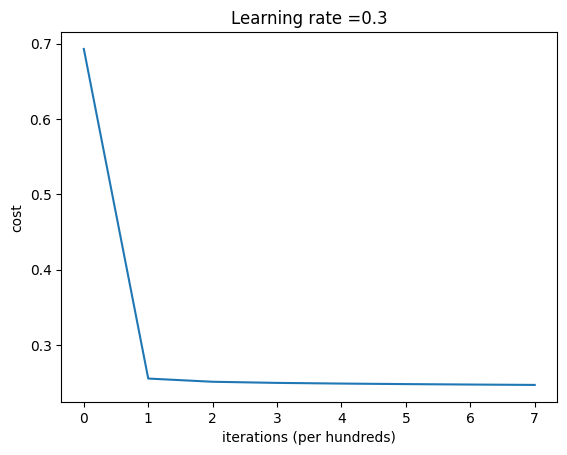

In [ ]:
# plot costs
def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
plot_costs(costs, learning_rate)

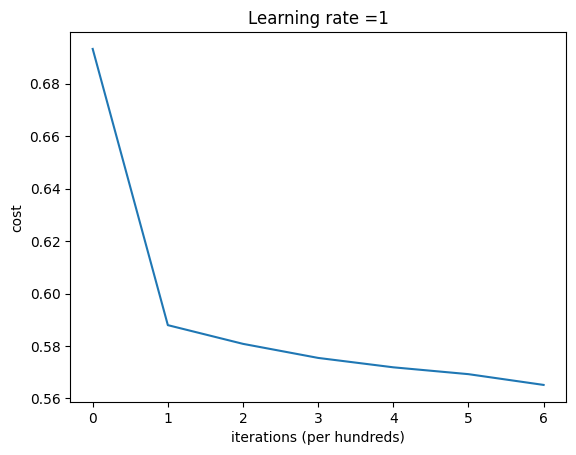

In [ ]:
# plot costs
def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
plot_costs(costs, learning_rate)

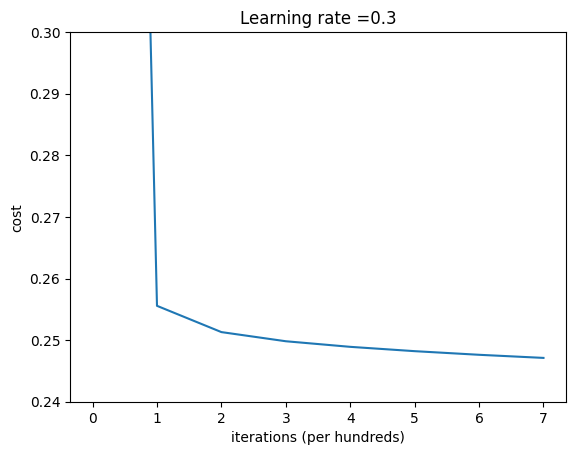

In [ ]:
# plot costs Zoom in
def plot_costs(costs, learning_rate=0.0075, y_min=0.24, y_max=None):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    
    if y_min is not None and y_max is not None:
        plt.ylim(y_min, y_max)
    
    plt.show()
    
plot_costs(costs, learning_rate, y_max=0.3)

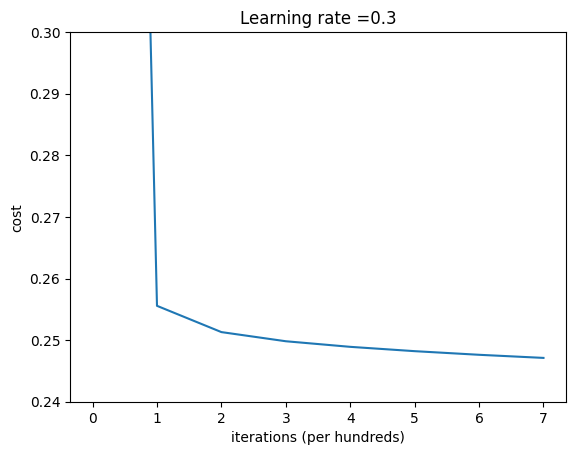

In [ ]:
# plot costs Zoom in
def plot_costs(costs, learning_rate=0.0075, y_min=0.24, y_max=None):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    
    if y_min is not None and y_max is not None:
        plt.ylim(y_min, y_max)
    
    plt.show()
    
plot_costs(costs, learning_rate, y_max=0.3)

<AxesSubplot: ylabel='Frequency'>

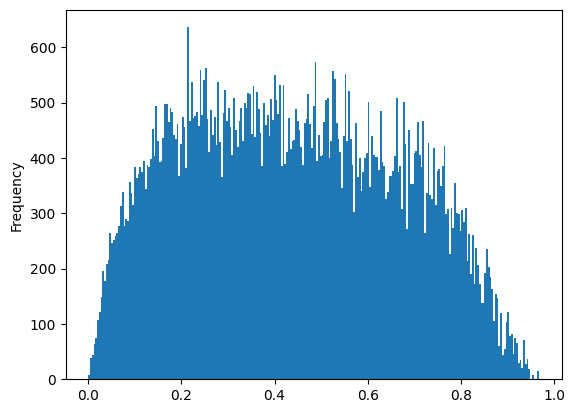

In [ ]:
# Last Model: Undersampling Set
train_proba = predict_proba(test_x_flatten, Y_test, parameters)
test_proba = predict_proba(test_x_flatten, Y_test, parameters)
pd.Series(train_proba).plot(kind="hist", bins=255, alpha=1)

<AxesSubplot: ylabel='Frequency'>

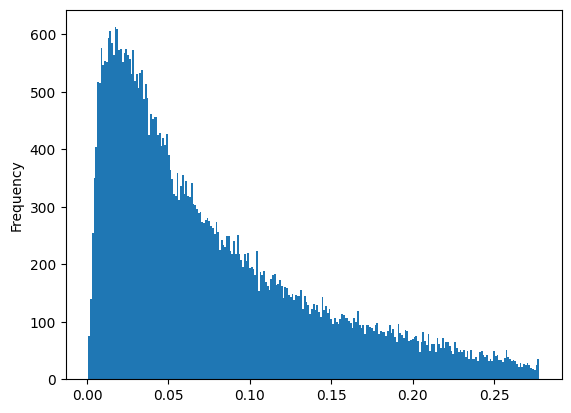

In [ ]:
# Last Model: Original Set
pd.Series(train_proba).plot(kind="hist", bins=255, alpha=1)

In [ ]:
# Confusion Matrix

recall_score(y_true=y_val, y_pred=test_proba > 0.5) # mayor a 0.44
f1_score(y_true=y_val, y_pred=test_proba > 0.5) #
confusion_matrix(y_true=y_val, y_pred=test_proba > 0.5, normalize="all", )
cm = pd.DataFrame(confusion_matrix(y_true=y_val, y_pred=test_proba > 0.271))
cm

ValueError: Found input variables with inconsistent numbers of samples: [49202, 8044]

In [ ]:
# Binary Prediction
threshold = 0.271

print("Train score:")
predictions_train = predict(train_x_flatten, Y, parameters, threshold=threshold)

print("Test score (val):")
predictions_test = predict(test_x_flatten, Y_test, parameters, threshold=threshold)

Train score:
Accuracy: 0.9202
Test score (val):
Accuracy: 0.9178


In [ ]:
# ROC AUC Score
# try:
#     train_score = roc_auc_score(y_true=Y, y_score=train_proba)
#     test_score = roc_auc_score(y_true=Y_test, y_score=test_proba)
#     print()
#     print("Train ROC AUC Score: {:.4f}".format(train_score))
#     print("Test ROC AUC Score: {:.4f}".format(test_score))
# except:
#     print("There are only one class in the target variable")

train_score = roc_auc_score(y_true=Y[0], y_score=predictions_train[0])
test_score = roc_auc_score(y_true=Y_test[0], y_score=predictions_test[0])
print()
print("Train ROC AUC Score: {:.4f}".format(train_score))
print("Test ROC AUC Score: {:.4f}".format(test_score))



Train ROC AUC Score: 0.5089
Test ROC AUC Score: 0.5064


In [ ]:
# Summary

vc_train_real = y_train.value_counts()
vc_test_real = y_val.value_counts()

vc_train = pd.Series(Y[0]).value_counts()
vc_test = pd.Series(Y_test[0]).value_counts()

vcr_train_pct = (vc_train_real / vc_train_real.sum()) *100
vcr_test_pct = (vc_test_real / vc_test_real.sum()) *100


vc_train_pct = ((vc_train / vc_train.sum()) *100)
vc_test_pct = ((vc_test / vc_test.sum()) *100)

print("="*20, "Real", "="*20)
print(f"Percentage Value Counts Train: \n{round(vcr_train_pct, 1).to_string()}")
print(f"Percentage Value Counts Test: \n{round(vcr_test_pct, 1).to_string()}")
print("="*17, "Predictions", "="*17)
print(f"Percentage Value Counts Train: \n{round(vc_train_pct, 1).to_string()}")
print(f"Percentage Value Counts Test: \n{round(vc_test_pct, 1).to_string()}")
print("="*47)

==================== Real ====================
Percentage Value Counts Train: 
0    92.0
1     8.0
Percentage Value Counts Test: 
0    91.8
1     8.2
================= Predictions =================
Percentage Value Counts Train: 
0    92.0
1     8.0
Percentage Value Counts Test: 
0    91.8
1     8.2


# Predictions

In [ ]:
error

In [ ]:
import pickle

with open("data-15_12-15_56_42-backup.pkl", "rb") as f:
    real_data = pickle.load(f)
real_data

,index,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,HOUSETYPE_MODE_terraced_house,HOUSETYPE_MODE_nan,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stone_brick,WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan
0,0,138399,0,202500.0,495216.0,30055.5,427500.0,0.030755,-12142,-2851.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,263198,0,225000.0,675000.0,19863.0,675000.0,0.014520,-13619,-6391.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,114902,0,103500.0,327024.0,18391.5,270000.0,0.025164,-19763,-253.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3,408795,4,225000.0,284400.0,13387.5,225000.0,0.010500,-13348,-1897.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,282313,0,157500.0,1125000.0,32895.0,1125000.0,0.026392,-17762,-2805.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61498,61498,413713,0,90000.0,845811.0,35964.0,756000.0,0.035792,-22322,-1649.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
61499,61499,342304,1,157500.0,247500.0,12375.0,247500.0,0.031329,-15179,-8501.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
61500,61500,235580,0,202500.0,450000.0,22860.0,450000.0,0.011703,-9912,-416.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
61501,61501,259162,3,180000.0,418743.0,25749.0,342000.0,0.020713,-14376,-7179.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
recall_score(y_true=y_val, y_pred=log_reg_val > 0.5) # mayor a 0.44
f1_score(y_true=y_val, y_pred=log_reg_val > 0.5) #
confusion_matrix(y_true=y_val, y_pred=log_reg_val > 0.5, normalize="all", )
cm = pd.DataFrame(confusion_matrix(y_true=y_val, y_pred=log_reg_val > 0.44))
cm

,0,1
0,45098,82
1,3973,49


In [ ]:
# ROC AUC Score
real_score = roc_auc_score(y_true=y_test_real, y_score=real_proba)

print()
print("Real ROC AUC Score: {:.4f}".format(real_score))



Real ROC AUC Score: 0.5000
